In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [2]:
# read 7-year-old data
data_path = './ncds_sweep0-3/tab/ncds0123.tab'
data = pd.read_csv(data_path, delimiter='\t').set_index('ncdsid')

/Users/hung-yiwu/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2,3,4,5,1756,1757,1758,1759,1760,1761,1762,1763,1764) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# n415: 1M Epileptic condition
# 2: no
# 1, -1: defect data
# obtained at 1965, 7y

# n2032: 3M Epilepsy
# 1: no
# -1: defect data
# obtained at 1974, 16y

# focus on those not epileptic at 1965 but epileptic at 1969

mask_1M_no = data['n415'] == '2'

mask_3M_no = (data['n2032'] == '1')
mask_3M_defect = (data['n2032'] == '-1') | (data['n2032'] == ' ') | (data['n2032'] == '2')
mask_3M_yes = ~(mask_3M_no | mask_3M_defect)

mask_1M_no_3M_yes = mask_1M_no & mask_3M_yes

print '{} people have no epilepsy at 1965 (7-year-old)'.format(sum(mask_1M_no))
print '{} people have epilepsy at 1974 (16-year-old)'.format(sum(mask_3M_yes))
print '{} people have no epilepsy at 7-year-old but have epilepsy at 16-year-old'.format(\
    sum(mask_1M_no_3M_yes))
print '\nTheir id number:'
print data.index[mask_1M_no_3M_yes].values

13901 people have no epilepsy at 1965 (7-year-old)
60 people have epilepsy at 1974 (16-year-old)
32 people have no epilepsy at 7-year-old but have epilepsy at 16-year-old

Their id number:
['N10166J' 'N10171F' 'N10370L' 'N10597D' 'N10926A' 'N11763D' 'N11767H'
 'N12258V' 'N13349B' 'N14147X' 'N17236K' 'N17347R' 'N17839G' 'N18241L'
 'N18731Z' 'N19076V' 'N19158W' 'N20286W' 'N20371S' 'N20374V' 'N22184Z'
 'N22487M' 'N22895Z' 'N23481K' 'N24216Y' 'N24233Z' 'N24494U' 'N25162F'
 'N25418L' 'N25591Y' 'N26543U' 'N27163Q']


In [4]:
doi = data[mask_1M_no]
y_df = pd.Series( np.zeros(data.shape[0]) )
y_df[mask_1M_no_3M_yes.values] = 1
y_df = y_df[mask_1M_no.values]

mask_3M_defect = (doi['n2032'] == '-1') | (doi['n2032'] == ' ') | (doi['n2032'] == '2')
y_df = y_df[~mask_3M_defect.values]

print 'Epilepsy condition survey:'
print y_df.value_counts()

Epilepsy condition survey:
0.0    9382
1.0      32
dtype: int64


In [5]:
# file path of explain file
explain_path = '/Users/hung-yiwu/Documents/AC209a_project/data/ncds_sweep0-3/mrdoc/allissue/ncds0123_ukda_data_dictionary.rtf'

# open explain file
explain = open(explain_path, 'r')

# read the whole file as a single giant string
explain_text = explain.read()

# SPSS measurement level target string
target_string_1 = 'the SPSS measurement level is '

# locate SPSS measurement level
target_loc_1 = [m.end() for m in re.finditer(target_string_1, explain_text)]

# variable label target string
target_string_2 = 'Variable label = '

# locate variable label
target_loc_2 = [m.end() for m in re.finditer(target_string_2, explain_text)]

# remove the first one (id)
target_loc_2 = target_loc_2[1:]

# variable code target string
target_string_3 = 'Variable = '

# locate variable code
target_loc_3 = [m.end() for m in re.finditer(target_string_3, explain_text)]

# remove the first one (id)
target_loc_3 = target_loc_3[1:]

In [6]:
var_df = pd.DataFrame({}, columns = ['type', 'label'])

for i in range(len(target_loc_1)):
    # get variable code
    start_pt = target_loc_3[i]+15
    end_pt = explain_text.find('cf1', start_pt)-6
    var_code = explain_text[start_pt:end_pt]
    
    # get variable label
    start_pt = target_loc_2[i]+7
    end_pt = explain_text.find('\par', start_pt)
    var_label = explain_text[start_pt:end_pt]
    
    # get variable type
    char = explain_text[target_loc_1[i] + 9] 
    if char == 'O' or char == 'o' or char == 'N' or char == 'n' \
        or 'region' in var_code:
        var_type = 'categorical'
    else:
        var_type = 'numerical'

    # append to DataFrame
    var_df.loc[var_code] = [var_type, var_label]

In [7]:
print '{} predictors'.format(var_df.shape[0])
print 'sample predictor list:'
var_df.head()

1764 predictors
sample predictor list:


,type,label
n622,categorical,0-3D Sex of child
n0region,categorical,Region at PMS (1958) - Birth
n1region,categorical,Region at NCDS1 (1965) - 7 years
n2region,categorical,Region at NCDS2 (1969) - 11 years
n3region,categorical,Region at NCDS3 (1974) - 16 years


In [8]:
variable_of_interest = []
for index, row in var_df.iterrows():
    starting_text = row['label'][0:1]
    if 'epilep' in row['label'] or 'Epilep' in row['label']:
        continue
    if 'convuls' in row['label'] or 'Convuls' in row['label']:
        continue
    if 'Special Education' in row['label']:
        continue
    if 'Region' in row['label']:
        continue
    if 'neuro' in row['label']:
        continue
    if 'Reason' in row['label'] or 'reason' in row['label']:
        continue
    if 'handicap' in row['label']:
        continue
    if 'psychi' in row['label']:
        continue
    if 'patient' in row['label']:
        continue
    if 'hcap' in row['label'] or 'Hcap' in row['label']:
        continue
    if index == 'n1910':
        continue
    if index == 'n1964':
        continue
    if index == 'n2032':
        continue
    if index == 'n2416':
        continue
    if index == 'n2598':
        continue
    if index == 'n2603':
        continue
    if index == 'n2604':
        continue
    if index == 'n2605':
        continue
    if index == 'n2606':
        continue
    if index == 'n2607':
        continue
    if index == 'n2608':
        continue
    if index == 'n2663':
        continue
    if index == 'n2664':
        continue
    if index == 'n2665':
        continue
    if index == 'n2666':
        continue
    if index == 'n2667':
        continue
    if index == 'n622' or starting_text == '2' or starting_text == '3':
        variable_of_interest.append(index)

print '{} predictors in file'.format( var_df.shape[0] )
print '{} predictors of interest'.format( len(variable_of_interest) )

1764 predictors in file
1194 predictors of interest


In [9]:
x_df = doi[variable_of_interest]
x_df = x_df[~mask_3M_defect]

In [10]:
# iterate through all variables
# dummify categorical variables
# standardize numeric variables

x_df_extended_list = []

for col in x_df.columns:
    # if this column is categorical
    if var_df.loc[col, 'type'] == 'categorical':
        # copy current column
        curr_df = x_df[col].copy()
        # format all value to string
        curr_df = curr_df.astype(str)
        # set value ' ' to value '-1'
        curr_df[curr_df == ' '] = '-1'
        # if this column contains NaN
        if curr_df.isnull().values.any():
            # get dummy with NaN as a unique value
            dummy = pd.get_dummies(curr_df, dummy_na = True)
        # if this column does not contain NaN
        else:
            # get dummy without considering NaN
            dummy = pd.get_dummies(curr_df, dummy_na = False)
        # reset column label of dummy
        dummy.columns = [str(col)+'='+str(value) for value in dummy.columns]
        # reset index label of dummy
        dummy.index = x_df.index
        # append current dummy DataFrame to master list
        x_df_extended_list.append(dummy)
    # if this column is numerical
    else:
        # copy current column
        curr_df = x_df[col].copy()
        # set value ' ' to value -1
        curr_df[curr_df == ' '] = -1
        # set value NaN to value -1
        curr_df[curr_df.isnull()] = -1
        # convert current column to float
        curr_df = curr_df.astype(float)
        # standardize it
        curr_df = pd.DataFrame(scale(curr_df.values))
        # reset index label of current DataFrame
        curr_df.index = x_df.index
        # reset column name of current DataFrame
        curr_df.columns = [col]
        # append current DataFrame to master list
        x_df_extended_list.append(curr_df)
        
# concatenate master list to get master data
x_df_extended = pd.concat(x_df_extended_list, axis = 1)

print '{} observations'.format(x_df_extended.shape[0])
print '{} variables (after dummy expansion)'.format(x_df_extended.shape[1])

9414 observations
8717 variables (after dummy expansion)


In [11]:
def scorer_fn(estimator, x, y):
    y_predict = estimator.predict(x)
    cm = confusion_matrix(y, y_predict)
    if (cm[1,1]+cm[0,1]) == 0:
        return 0
    elif (cm[1,0]+cm[1,1]) == 0:
        return 0
    elif cm[1,1] == 0:
        return 0
    else:
        precision = float(cm[1,1])/float(cm[1,1]+cm[0,1])
        recall = float(cm[1,1])/float(cm[1,0]+cm[1,1])
        return precision * recall/(precision + recall)

In [12]:
weight_list = [{1:value} for value in 10**np.arange(0, 3, 1)]
parameters = {'class_weight':weight_list}
gscv = GridSearchCV(LogisticRegressionCV(), parameters, scoring = 'roc_auc')

gscv.fit(x_df_extended.values, y_df.values)
best_model = gscv.best_estimator_

In [13]:
best_model = gscv.best_estimator_

kf = KFold(n_splits = 3)
threshold_list = np.linspace(0.94, 0.97, 10)
adf = pd.DataFrame(0, columns = ['accuracy_all', 'accuracy_healthy', 'accuracy_epilepsy'],\
                  index = threshold_list)

for threshold in threshold_list:
    for train_index, test_index in kf.split(x_df_extended.values):
        x_train = x_df_extended.values[train_index, :]
        x_test = x_df_extended.values[test_index, :]
        y_train = y_df.values[train_index]
        y_test = y_df.values[test_index]
    
        best_model.fit(x_train, y_train)
    
        y_predict = best_model.predict_proba(x_test)[:, 0]
        mask = y_predict >= threshold
        y_predict[mask] = 0
        y_predict[~mask] = 1
    
        cm = confusion_matrix(y_test, y_predict)
        accuracy_all = float(cm[0,0]+cm[1,1])/float(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
        accuracy_epilepsy = float(cm[1,1])/float(cm[1,0]+cm[1,1])
        accuracy_healthy = float(cm[0,0])/float(cm[0,0]+cm[0,1])
    
        adf.loc[threshold] += [accuracy_all, accuracy_healthy, accuracy_epilepsy]
    adf.loc[threshold] /= 3

In [14]:
print 'Best parameter:', gscv.best_params_
print 'Best precision score:', gscv.best_score_
print adf

Best parameter: {'class_weight': {1: 10}}
Best precision score: 0.727136842918
          accuracy_all  accuracy_healthy  accuracy_epilepsy
0.940000      0.985235          0.988384           0.063636
0.943333      0.979711          0.982735           0.093939
0.946667      0.971001          0.973782           0.157576
0.950000      0.955173          0.957582           0.248485
0.953333      0.933503          0.935732           0.278788
0.956667      0.901848          0.903863           0.309091
0.960000      0.850436          0.852064           0.369697
0.963333      0.769174          0.769992           0.527273
0.966667      0.641810          0.641871           0.618182
0.970000      0.480773          0.479641           0.806061


In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_df_extended.values, y_df.values, test_size = 0.3)
best_model.fit(x_train, y_train)
y_predict_proba = best_model.predict_proba(x_test)

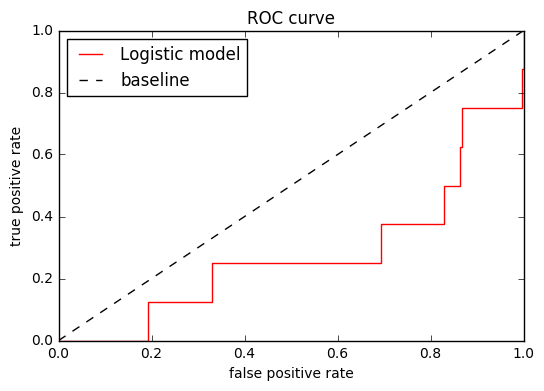

In [17]:
fpr, tpr, threshold = roc_curve(y_test, y_predict_proba[:, 0])
plt.plot(fpr, tpr, label = 'Logistic model', color = 'red', linestyle = '-')
plt.plot([0,1], [0,1], label = 'baseline', color = 'black', linestyle = '--')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curve')
plt.legend(loc = 'best')

In [18]:
# get coefficient
best_model = gscv.best_estimator_
coef = best_model.coef_.flatten()

most_pos_var_index = np.argsort(coef)[-21:][::-1]
most_neg_var_index = np.argsort(coef)[0:20]

print 'most positive variables'
for index in most_pos_var_index:
    print coef[index], x_df_extended.columns[index],
    
    # get variable name
    if '=' in x_df_extended.columns[index]:
        var_name = x_df_extended.columns[index].split('=', 1)[0]
    else:
        var_name = x_df_extended.columns[index]
    
    print var_df['label'].loc[var_name]

most positive variables
0.012411483472 n1185 2P Dads wks off work last yr thru illnss
0.00945177322001 n1008 2S BSAG Total score for all syndromes
0.00944603948158 n2275 3S Autumn-no. of half-days absent 1973
0.00928988684402 n2387 3P Dads wks off wrk last yr thru illness
0.00879277241699 n1608 2M Time picking up 20 matches-right hand
0.00867659733411 n1732 3P Persons per room-kitchen=living room
0.00842350175225 n2638=1 3P Seen other dentist past year M:C 1-5
0.00841790571514 n2415=1 3P Help nec aftr left sch due to handicp
0.007570508819 n1611 2M Time picking up 20 matches-left hand
0.00735181490499 n1507=1 2M Congenital,acquired condition,handicp
0.00734991555925 n1733 3P Persons per room-kitchen=6ft+ wide
0.00658274032473 n2336=2 3S Child poor hand control-teachers view
0.00615161330849 n2311=2 3S Cannot settle more than a few moments
0.00607117379799 n835 2S Full-time equiv of part-time teachers
0.00598613663041 n2285=8 3S Most suitable type further,highr educ
0.00569549918203 n21

In [19]:
doi_epil = x_df_extended[(y_df == 1).values]
doi_healthy = x_df_extended[(y_df == 0).values]

most positive variables
0.012411483472 n1185 2P Dads wks off work last yr thru illnss


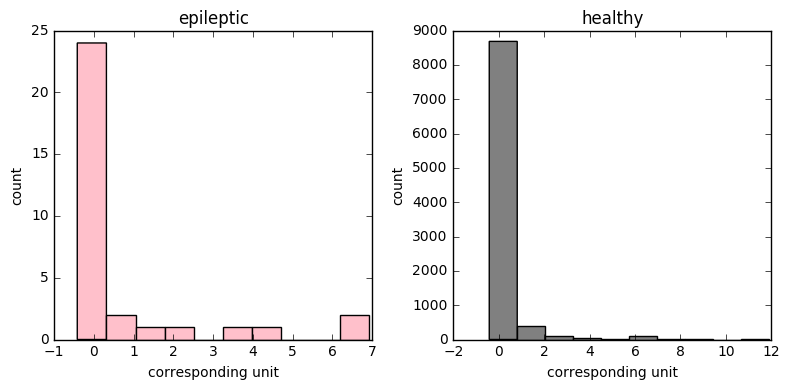

0.00945177322001 n1008 2S BSAG Total score for all syndromes


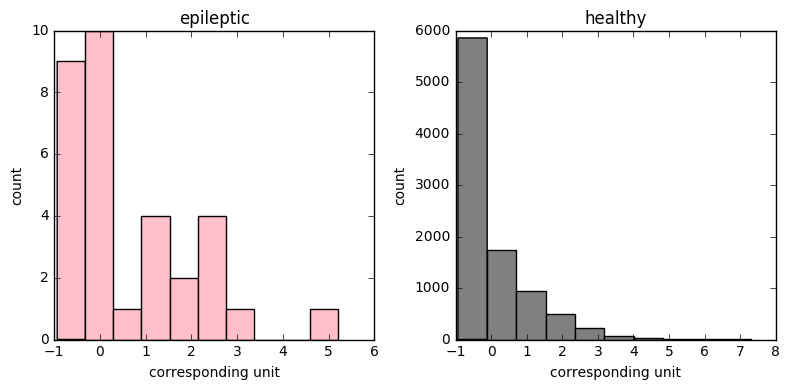

0.00944603948158 n2275 3S Autumn-no. of half-days absent 1973


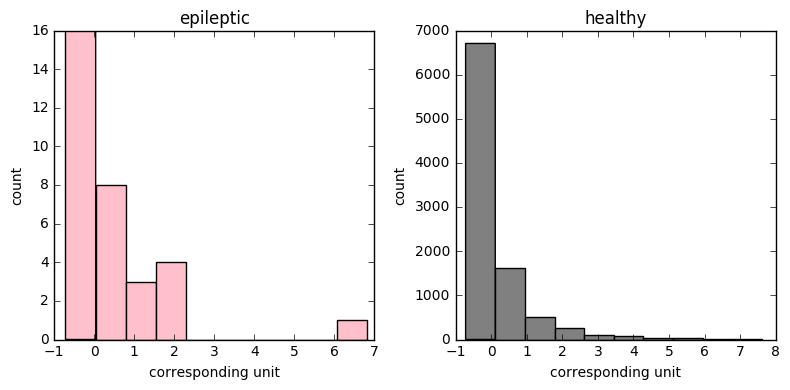

0.00928988684402 n2387 3P Dads wks off wrk last yr thru illness


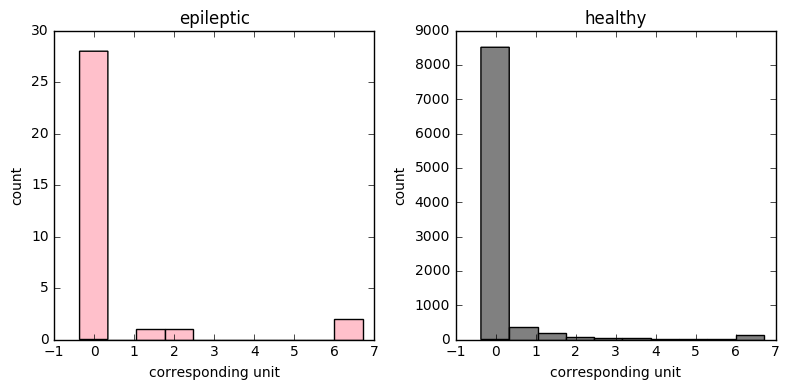

0.00879277241699 n1608 2M Time picking up 20 matches-right hand


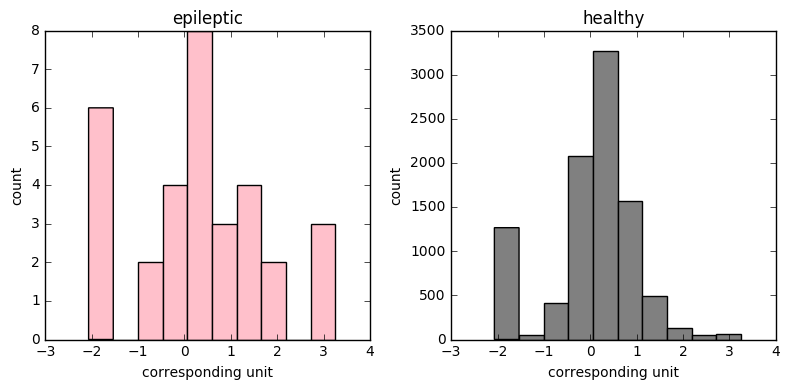

0.00867659733411 n1732 3P Persons per room-kitchen=living room


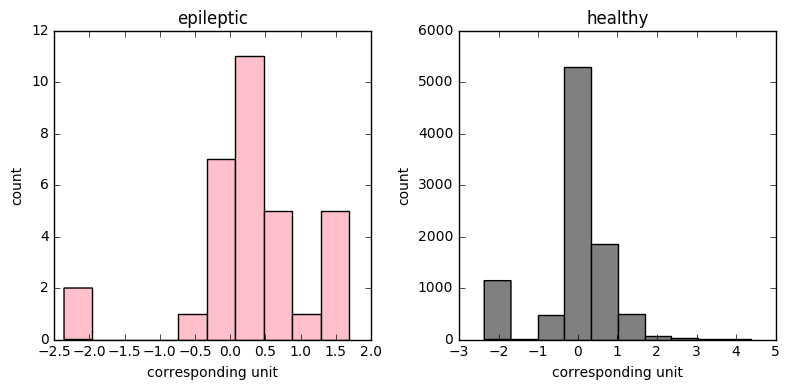

0.00842350175225 n2638=1 3P Seen other dentist past year M:C 1-5


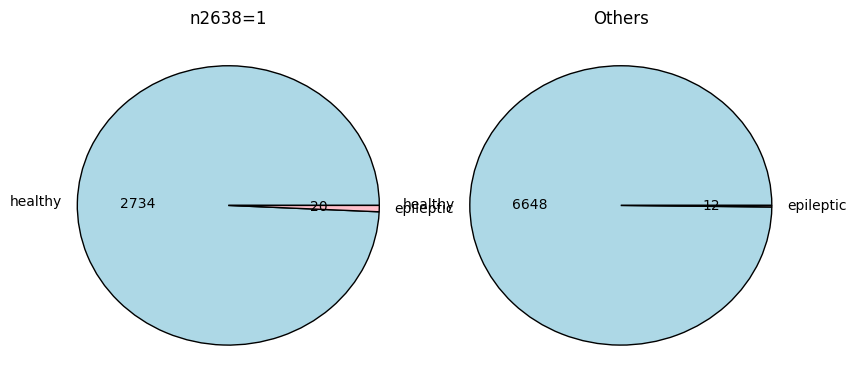

0.00841790571514 n2415=1 3P Help nec aftr left sch due to handicp


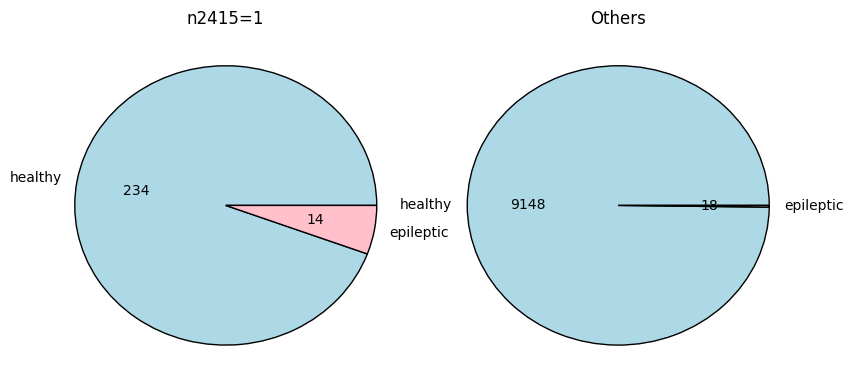

0.007570508819 n1611 2M Time picking up 20 matches-left hand


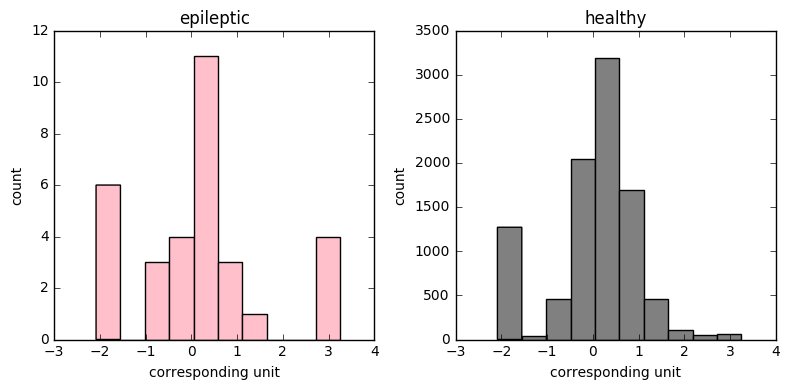

0.00735181490499 n1507=1 2M Congenital,acquired condition,handicp


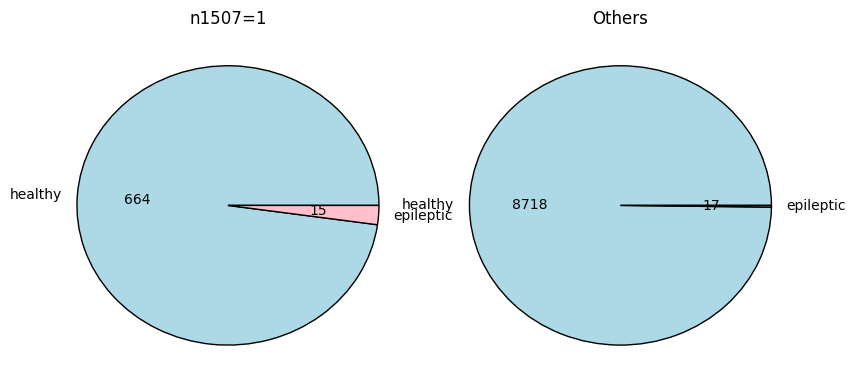

In [20]:
# get coefficient
best_model = gscv.best_estimator_
coef = best_model.coef_.flatten()

most_pos_var_index = np.argsort(coef)[-10:][::-1]
most_neg_var_index = np.argsort(coef)[0:20]

print 'most positive variables'
for index in most_pos_var_index:
    print coef[index], x_df_extended.columns[index],
    
    # get variable name and plot different figures
    # categorical
    if '=' in x_df_extended.columns[index]:
        var_name = x_df_extended.columns[index].split('=', 1)[0]
        var_name_full = x_df_extended.columns[index]
        print var_df['label'].loc[var_name]
        
        mask_positive = (x_df_extended[var_name_full] == 1).values
        positive = y_df[mask_positive].value_counts().sort_index()
        negative = y_df[~mask_positive].value_counts().sort_index()

        fig, axs = plt.subplots(1, 2, figsize = (8,4))
        if positive.shape[0] == 2:
            labels = ['healthy', 'epileptic']
        else: 
            labels = ['healthy']

        axs[0].pie(positive.values, labels = labels,\
            autopct=lambda(p): '{:.0f}'.format(p * sum(positive.values) / 100),\
            colors = ['lightblue', 'pink', 'gray'])
        axs[0].set_title(x_df_extended.columns[index])

        if negative.shape[0] == 2:
            labels = ['healthy', 'epileptic']
        else: 
            labels = ['healthy']

        axs[1].pie(negative.values, labels = labels,\
            autopct=lambda(p): '{:.0f}'.format(p * sum(negative.values) / 100),\
            colors = ['lightblue', 'pink', 'gray'])
        axs[1].set_title('Others')

        fig.tight_layout()
        #plt.savefig(x_df_extended.columns[index]+'.eps', format='eps', dpi=600)
        plt.show()
    # numerical
    else:
        var_name = x_df_extended.columns[index]
        print var_df['label'].loc[var_name]
    
        positive = x_df_extended.loc[(y_df == 1).values, var_name].values
        negative = x_df_extended.loc[(y_df == 0).values, var_name].values
        
        fig, axs = plt.subplots(1, 2, figsize = (8,4))
        
        axs[0].hist(positive, color = 'pink')
        axs[0].set_xlabel('corresponding unit')
        axs[0].set_ylabel('count')
        axs[0].set_title('epileptic')
        
        axs[1].hist(negative, color = 'gray')
        axs[1].set_xlabel('corresponding unit')
        axs[1].set_ylabel('count')
        axs[1].set_title('healthy')
        
        fig.tight_layout()
        #plt.savefig(x_df_extended.columns[index]+'.eps', format='eps', dpi=600)
        plt.show()